In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import seaborn  as sns
from tqdm import tqdm

In [15]:
# Load and preprocess `news`
news = pd.read_csv('data/bis_press_releases.csv')
news = news.dropna()
news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')

In [16]:
# Load and preprocess `df`
df = pd.read_csv('data/sp500_prices.csv')
df['date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Date'])
companies = df['Company'].unique().tolist()
dates = df['date'].drop_duplicates().values

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
class_labels = model.config.id2label
prob_labels = model.config.label2id

text1 = news['content'].values[0]
inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs)
print('labels assignation:', prob_labels)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Predicted class: negative
Probabilities: tensor([[0.2091, 0.7053, 0.0855]])
labels assignation: {'positive': 0, 'negative': 1, 'neutral': 2}


In [18]:
def sentiment_labelling(df):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    # Initialize sentiment columns
    df['negative'] = 0.0
    df['neutral'] = 0.0
    df['positive'] = 0.0

    # Initialize the tqdm progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment Analysis", dynamic_ncols=True):
        text = row['content']

        # Tokenize the text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Get predicted probabilities (softmax output)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()

        # Assign probabilities to the corresponding columns
        df.at[index, 'positive'] = probs[0]
        df.at[index, 'negative'] = probs[1]
        df.at[index, 'neutral'] = probs[2]

    # Drop unnecessary columns
    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    # Group by date and calculate mean sentiment scores
    df = df.groupby("date").mean().reset_index()

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Create a full date range
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

    # Reindex to include all dates and forward-fill missing values
    df = df.set_index("date").reindex(date_range)
    df = df.ffill().reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    # Sort by date in descending order
    df = df.sort_values(by="date", ascending=False).reset_index(drop=True)

    return df

In [19]:
news = sentiment_labelling(news)

Processing Sentiment Analysis: 100%|██████████| 7133/7133 [17:10<00:00,  6.93it/s]


In [20]:
def dates_filtering(news, df):
    # Ensure 'date' columns are in datetime format
    news['date'] = pd.to_datetime(news['date'])
    df['date'] = pd.to_datetime(df['date'])

    # Find the intersection of dates
    common_dates = set(news['date']).intersection(set(df['date']))

    # Filter rows from both DataFrames where the date is in the common_dates
    filtered_news = news[news['date'].isin(common_dates)]
    filtered_df = df[df['date'].isin(common_dates)]
    return filtered_news, filtered_df

In [21]:
news, df = dates_filtering(news, df)

In [ ]:
def preprocessing(news, df, include_news=True):
    data = []
    companies = df['Company'].drop_duplicates().values
    features = 400
    for company in tqdm(companies[:features]):
        company_data = df[df['Company'] == company]['High'].values
        company_data = (company_data[1:] - company_data[:-1]) / company_data[:-1]  # Compute returns
        data.append(company_data)

    data = np.array(data)  # Shape: (features, timesteps)
    if include_news:
        sentiment_data = []
        dates = df['date'].drop_duplicates().values

        for date in tqdm(dates[1:]):
            sentiment_data_day = news[news['date'] == date][['negative', 'positive', 'neutral']].values.flatten()
            sentiment_data.append(sentiment_data_day)

        sentiment_data = np.array(sentiment_data)  # Shape: (timesteps, sentiment_features)

        if data.shape[1] != sentiment_data.shape[0]:
            raise ValueError(f"Mismatch in timesteps: company_data ({data.shape[1]}) vs sentiment_data ({sentiment_data.shape[0]})")

        sentiment_data = sentiment_data.T  # Shape: (sentiment_features, timesteps)

        data = np.concatenate((data, sentiment_data), axis=0)  # Shape: (features + sentiment_features, timesteps)

    print("Combined data shape:", data.shape)
    return data

In [ ]:
data = preprocessing(news, df, include_news=True)

100%|██████████| 1998/1998 [00:00<00:00, 5756.17it/s]

Combined data shape: (403, 1998)


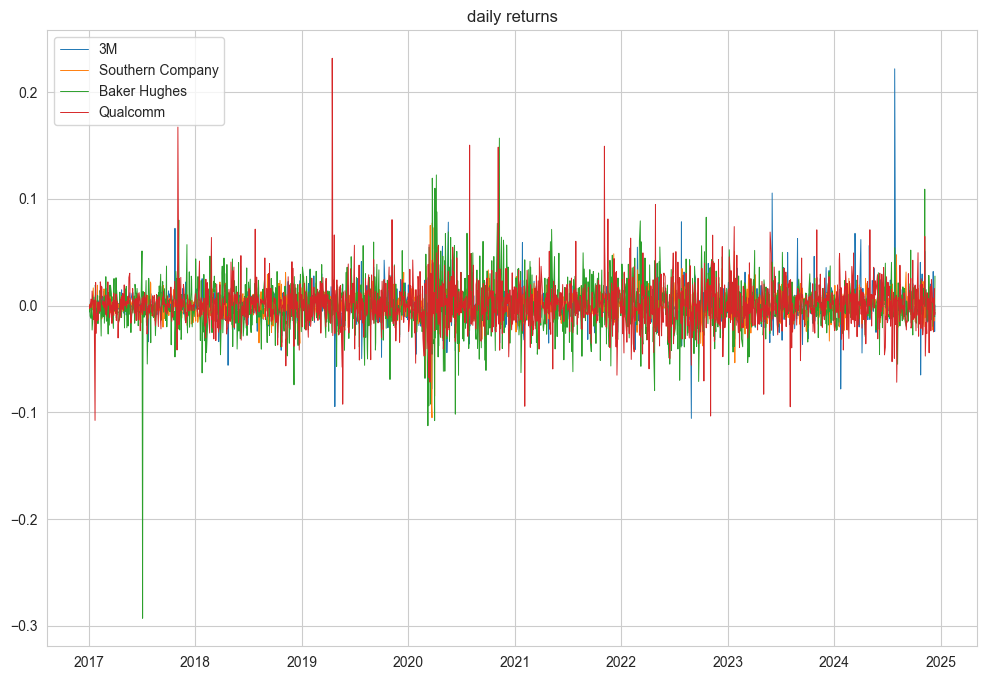

In [27]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
for k in range(4):
    plt.plot(dates[1:], data[k], label=companies[k], linewidth=0.7)
plt.title('daily returns')
plt.legend()
plt.show()

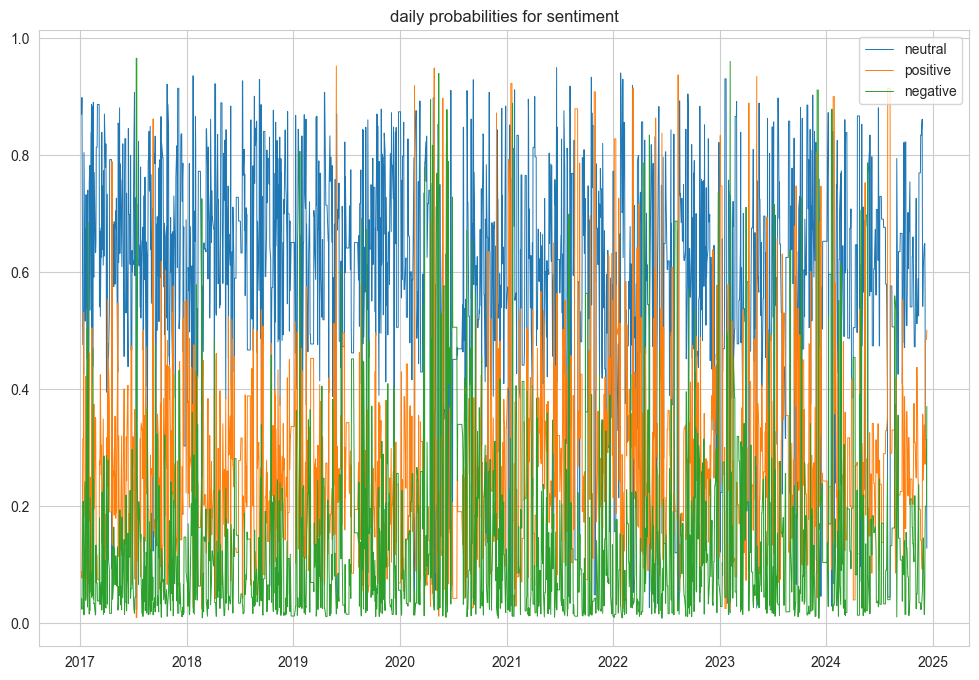

In [32]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
plt.plot(dates[1:], data[-1], label='neutral', linewidth=0.7)
plt.plot(dates[1:], data[-2], label='positive', linewidth=0.7)
plt.plot(dates[1:], data[-3], label='negative', linewidth=0.7)
plt.title('daily probabilities for sentiment')
plt.legend()

In [35]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

def data_sequencing(sequence_length, data, include_news=True):
    data_sequenced = []

    for i in range(len(data[0]) - sequence_length):
        data_sequenced.append(data[:, i:i+sequence_length])
    data_sequenced = np.array(data_sequenced) # Shape : (num_sequences, num_series, timesteps=sequence_length-1)

    X_scaled_sequenced = torch.tensor(data_sequenced, dtype=torch.float32)
    if include_news:
        X_tensors = X_scaled_sequenced[:, :, :-1]  # All but the last value as features
        y_tensors = X_scaled_sequenced[:, :-3, -1]   # Last value as target, without the sentiment
    else:
        X_tensors = X_scaled_sequenced[:, :, :-1]  # All but the last value as features
        y_tensors = X_scaled_sequenced[:, :, -1]   # Last value as target, without the sentiment
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_tensors, y_tensors, test_size=0.2, random_state=42)

    # Create DataLoader for batching
    batch_size = 16
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return X_train, y_train, X_val, y_val, train_loader, val_loader

In [36]:
X_train, y_train, X_val, y_val, train_loader, val_loader = data_sequencing(100, data)

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, intermediate_size=256, dropout=0.2):
        super(LSTM, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(intermediate_size, intermediate_size)
        self.tanh = nn.Tanh()
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(intermediate_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states to zeros
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)  # Cell state
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the last time step's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Fully connected layer to produce the final output
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.dropout2(out)
        out = self.fc3(out) # Shape: (batch_size, output_size)
        
        return out

In [38]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt', verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            path (str): Path to save the best model.
            verbose (bool): Print messages about early stopping.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Save the model when validation loss improves."""
        if self.verbose:
            print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        torch.save(model.state_dict(), self.path)

In [39]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

# Hyperparameters
hidden_size = 128
num_layers = 6
dropout = 0.1

learning_rate = 0.02
num_epochs = 200

# Initialize the LSTM model
model = LSTM(input_size, hidden_size, output_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=50, verbose=True)

In [40]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.permute(0, 2, 1)  # Shape: (batch_size, sequence_length, input_size)
        y_batch = y_batch  # Shape: (batch_size, num_features)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.permute(0, 2, 1)  # Shape: (batch_size, sequence_length, input_size)
            y_batch = y_batch  # Shape: (batch_size, num_features)
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"\nEpoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")

    # Check early stopping
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("\n     ###################     \n Early stopping triggered \n     ###################     ")
        break


Epoch 1, Train Loss: 0.110626, Validation Loss: 0.000385
Validation loss decreased to 0.000385. Saving model...

Epoch 2, Train Loss: 0.000504, Validation Loss: 0.000421
EarlyStopping counter: 1 out of 50

Epoch 3, Train Loss: 0.000433, Validation Loss: 0.000428
EarlyStopping counter: 2 out of 50

Epoch 4, Train Loss: 0.000385, Validation Loss: 0.000381
Validation loss decreased to 0.000381. Saving model...

Epoch 5, Train Loss: 0.000369, Validation Loss: 0.000382
EarlyStopping counter: 1 out of 50

Epoch 6, Train Loss: 0.000364, Validation Loss: 0.000382
EarlyStopping counter: 2 out of 50

Epoch 7, Train Loss: 0.000365, Validation Loss: 0.000385
EarlyStopping counter: 3 out of 50

Epoch 8, Train Loss: 0.000365, Validation Loss: 0.000382
EarlyStopping counter: 4 out of 50

Epoch 9, Train Loss: 0.000365, Validation Loss: 0.000382
EarlyStopping counter: 5 out of 50

Epoch 10, Train Loss: 0.000370, Validation Loss: 0.000388
EarlyStopping counter: 6 out of 50

Epoch 11, Train Loss: 0.0003

In [41]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.permute(0, 2, 1)  # Add feature dimension
        y_batch = y_batch

        # Forward pass
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # Multiply by batch size to account for averaging

    # Calculate the average loss over the entire test set
    test_loss = total_loss / len(val_loader.dataset)
    print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.000392


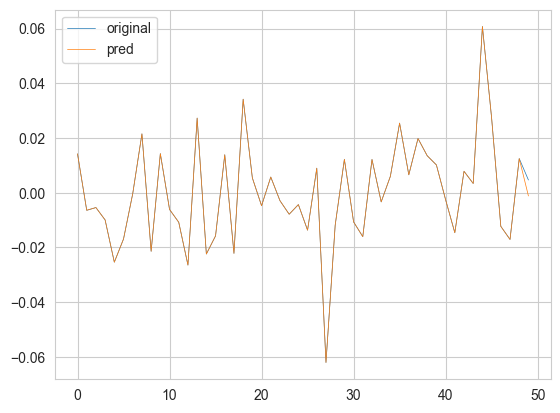

In [51]:
# Randomly pick a sample from the validation set
i = np.random.randint(0, X_val.shape[0])
j = np.random.randint(0, X_val.shape[1])
with torch.no_grad():
    # Prepare input
    x = X_val[i].unsqueeze(0).permute(0, 2, 1)  # Shape: (1, sequence_length, input_size)
    y = y_val[i].unsqueeze(0)  # Shape: (1, num_features)

    # Predict
    y_pred = model(x)  # Shape: (1, num_features)

    # Convert tensors to NumPy arrays for processing
    x = x.squeeze(0).permute(1, 0).numpy()[:-3, :]  # Shape: (sequence_length, input_size)
    y = y.squeeze(0).numpy()  # Shape: (num_features,)
    y_pred = y_pred.squeeze(0).numpy()  # Shape: (num_features,)


    # Append the predicted and actual target values as the last "step" in the input sequence
    x_org = np.concatenate((x, y.reshape(-1, 1)), axis=1)[j]  # Append `y_resized` as the last step
    x_pred = np.concatenate((x, y_pred.reshape(-1, 1)), axis=1)[j]  # Append `y_pred_resized` as the last step
    # Extract the last 50 points for visualization
    x_org_last = x_org[-50:]
    x_pred_last = x_pred[-50:]

    # Plot the original and predicted sequences
    plt.plot(x_org_last, linewidth=0.5, label="original")  # Plot the last feature dimension
    plt.plot(x_pred_last, linewidth=0.5, label="pred")    # Plot the last feature dimension
    plt.legend()
    plt.show()